<a href="https://colab.research.google.com/github/raj-027/Sanskrit-NLP/blob/main/Evaluation_suite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
import pickle
import random
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import re

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


Load words to compute


In [3]:
def load_words(path):
     words = []
     with open(path, "r", encoding="utf-8") as f:
        for text in f:
            text = re.sub(r"[०-९\d]", "", text)        # remove digits
            text = re.sub(r"[।॥]", " ", text)         # replace danda marks with space
            text = re.sub(r"[^ऀ-ॿ ]", " ", text)      # keep only Devanagari + space
            text = re.sub(r"\s+", " ", text)
            for w in text.split():
                if w:
                    words.append(w)
     return words

corpus_path = "/content/drive/MyDrive/Sanskrit NLP/पाणिनीय शिक्षा.txt"
words = load_words(corpus_path)
print(len(words))
print("Example:", words[:100])
vocab = set(words)
print("unique words: ",len(vocab))

551
Example: ['पाणिनीय', 'शिक्षा', 'अथ', 'शिक्षां', 'प्रवक्ष्यामि', 'पाणिनीयं', 'मतं', 'यथा', 'शास्त्रानुपूर्वं', 'तद्विद्याद्यथोक्तं', 'लोकवेदयोः', 'प्रसिद्धमपि', 'शब्दार्थमविज्ञातमबुद्धिभिः', 'पुनर्व्यक्तीकरिष्यामि', 'वाच', 'उच्चारणे', 'विधिम्', 'त्रिषष्टिश्चतुःषष्टिर्वा', 'वर्णाः', 'शम्भुमते', 'मताः', 'प्राकृते', 'संस्कृते', 'चापि', 'स्वयं', 'प्रोक्ताः', 'स्वयम्भुवा', 'स्वराविंशतिरेकश्च', 'स्पर्शानां', 'पञ्चविंशतिः', 'यादयश्च', 'स्मृता', 'ह्यष्टौ', 'चत्वारश्च', 'यमाः', 'स्मृताः', 'अनुस्वारो', 'विसर्गश्च', 'क', 'पौ', 'चापि', 'पराश्रितौ', 'दुस्पृष्टश्चेति', 'विज्ञेयो', 'ॡकारः', 'प्लुत', 'एव', 'च', 'आत्मा', 'बुद्ध्या', 'समेत्यार्थान्मनोयुङ्क्ते', 'विवक्षया', 'मनः', 'कायाग्निमाहन्ति', 'स', 'प्रेरयति', 'मारुतम्', 'मारुस्तूरसिचरन्मन्द्रं', 'जनयति', 'स्वरम्', 'प्रातःसवनयोगं', 'तं', 'छन्दोगायत्रमाश्रितम्', 'कण्ठेमाध्यन्दिनयुगं', 'मध्यमं', 'त्रैष्टुभानुगम्', 'तारं', 'तार्तीयसवनं', 'शीर्षण्यं', 'जागतानुगतम्', 'सोदीर्णो', 'मूर्ध्न्यभिहतोवक्रमापद्य', 'मारुतः', 'वर्णाञ्जनयतेतेषां', 'विभागः', 'पञ

Panphon articulatory distance

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Sanskrit NLP/sanskrit_phoneme_vectors (1).csv", index_col=0)

phoneme_vectors = {
    row.Index: np.array(row[1:], dtype=float)
    for row in df.itertuples()
}

print(f"Loaded {len(phoneme_vectors)} Sanskrit phonemes with 34 features.")


def panphon_segment_distance(a, b):
    if a not in phoneme_vectors or b not in phoneme_vectors:
        return 1.0
    vec_a = phoneme_vectors[a]
    vec_b = phoneme_vectors[b]
    return np.sum(np.abs(vec_a - vec_b)) / len(vec_a)

def panphon_word_distance(word1: str, word2: str) -> float:
    n, m = len(word1), len(word2)
    dp = np.zeros((n + 1, m + 1))

    for i in range(1, n + 1):
        dp[i][0] = i
    for j in range(1, m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            sub_cost = panphon_segment_distance(word1[i - 1], word2[j - 1])
            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + sub_cost
            )

    return dp[n][m] / max(n, m)


Loaded 52 Sanskrit phonemes with 34 features.


# Load Models


Defineing Phonetic Encoder

In [5]:
import torch.nn as nn
#Encoder for triplet model

class Phonetic_triplet_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, layers=2, proj_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=layers,
            batch_first=True,
            bidirectional=True
        )
        self.proj = nn.Linear(hidden_dim * 2, proj_dim)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)

        mask = torch.arange(out.size(1)).to(lengths.device)[None, :] < lengths[:, None]
        mask = mask.unsqueeze(-1)

        pooled = (out * mask).sum(dim=1) / lengths.unsqueeze(1)

        return self.proj(pooled)

In [6]:
#Encoder for Metric model
class Phonetic_metric_Encoder(nn.Module):
    def __init__(self, feature_dim, hidden_dim = 128, emb_dim = 64):
        super().__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, batch_first=True)
        self.proj = nn.Linear(hidden_dim, emb_dim)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        emb = self.proj(h_n[-1])
        return emb

In [7]:
# Loading Triplet model
FEATURE_DIM = 34 # Define FEATURE_DIM based on the number of features in phoneme_vectors
triplet_model = Phonetic_triplet_Encoder(
    FEATURE_DIM # Using default hidden_dim=256, layers=2, proj_dim=128 from class definition
)

triplet_model.load_state_dict(
    torch.load("/content/drive/MyDrive/Sanskrit NLP/models/sanskrit_phonetic_TML_model_35-10.pkl", map_location=device)
)

triplet_model.to(device)
triplet_model.eval()

Phonetic_triplet_Encoder(
  (lstm): LSTM(34, 256, num_layers=2, batch_first=True, bidirectional=True)
  (proj): Linear(in_features=512, out_features=128, bias=True)
)

In [8]:
#Loading metric learning model

metric_model = Phonetic_metric_Encoder(
    FEATURE_DIM
)

metric_model.load_state_dict(
    torch.load("/content/drive/MyDrive/Sanskrit NLP/models/sanskrit_metric_learning_model_50-10.pt", map_location=device)
)

metric_model.to(device)
metric_model.eval()

Phonetic_metric_Encoder(
  (lstm): LSTM(34, 128, batch_first=True)
  (proj): Linear(in_features=128, out_features=64, bias=True)
)

In [9]:
# Words to feature sequence
def word_to_feature_tensor(word):
    vectors = []
    for ch in word:
        if ch in phoneme_vectors:
            vectors.append(phoneme_vectors[ch])
        else:
            vectors.append(np.zeros(34))
    # Convert list of arrays to a single numpy array before converting to tensor
    return torch.tensor(np.array(vectors), dtype=torch.float32)

def euclidean_similarity(vec1, vec2):
    return -np.linalg.norm(vec1 - vec2)

Get Embeddings

In [10]:
def get_embeddings(model, words):
    embeddings = {}

    with torch.no_grad():
        for w in words:
            feature_tensor = word_to_feature_tensor(w).to(device)
            feature_tensor_batched = feature_tensor.unsqueeze(0)

            length = torch.tensor(
                [feature_tensor.size(0)],
                dtype=torch.long
            ).to(device)

            vec = model(feature_tensor_batched, length)

            # ❌ REMOVE NORMALIZATION
            vec = vec.squeeze(0)

            embeddings[w] = vec.cpu().numpy()

    return embeddings

Precompute Panphon-Articulatory Distance matrix

In [11]:
print("Precomputing PanPhon distance matrix...")

panphon_dist = {}

for w1, w2 in combinations(words, 2):
    d = panphon_word_distance(w1, w2)
    panphon_dist[(w1, w2)] = d
    panphon_dist[(w2, w1)] = d

def A(w1, w2):
    if w1 == w2:
        return 0.0
    return panphon_dist[(w1, w2)]

Precomputing PanPhon distance matrix...


correlation evaluation

In [12]:
def evaluate_correlation(embeddings):

    sp_scores = []
    embed_scores = []

    for w1, w2 in combinations(words, 2):
        sp = -A(w1, w2)

        if embeddings is None:
            sim = sp
        else:
            sim = euclidean_similarity(
                embeddings[w1],
                embeddings[w2]
            )

        sp_scores.append(sp)
        embed_scores.append(sim)

    pear = pearsonr(sp_scores, embed_scores)[0]
    spear = spearmanr(sp_scores, embed_scores)[0]

    return pear, spear

Retrieval Evaluation

In [13]:
def evaluate_retrieval(embeddings):

    percentiles = []

    for w in words:

        candidates = [x for x in words if x != w]
        true_neighbor = min(candidates, key=lambda x: A(w,x))

        if embeddings is None:
            percentiles.append(1.0)
            continue

        sims = [(x, euclidean_similarity(
                    embeddings[w],
                    embeddings[x]
                )) for x in candidates]

        sims.sort(key=lambda x: x[1], reverse=True)
        ranked = [x[0] for x in sims]

        rank = ranked.index(true_neighbor)
        percentile = (len(candidates) - rank) / len(candidates)
        percentiles.append(percentile)

    return np.mean(percentiles)

Synthetic sound analogy

In [14]:
def generate_analogies(num_samples=100):
    quadruples = []

    for _ in range(num_samples):
        w1 = random.choice(words)

        # nearest neighbor under PanPhon
        w2 = min(
            [x for x in words if x != w1],
            key=lambda x: A(w1, x)
        )

        w3 = random.choice(words)

        w4 = min(
            [x for x in words if x != w3],
            key=lambda x: A(w3, x)
        )

        quadruples.append((w1, w2, w3, w4))

    return quadruples

In [15]:
def evaluate_analogies(embeddings):

    quadruples = generate_analogies()
    correct = 0

    for w1,w2,w3,w4 in quadruples:

        if embeddings is None:
            continue

        vec = embeddings[w2] - embeddings[w1] + embeddings[w3]

        sims = [(x, euclidean_similarity(
                    vec,
                    embeddings[x]
                )) for x in words]

        sims.sort(key=lambda x: x[1], reverse=True)

        if sims[0][0] == w4:
            correct += 1

    return correct / len(quadruples)

Run eveluation

In [16]:
from tqdm.auto import tqdm

triplet_emb = get_embeddings(triplet_model, words)
metric_emb = get_embeddings(metric_model, words)

systems = {
    "Triplet": triplet_emb,
    "Metric": metric_emb,
    "PanPhon": None
}

results = {}

for name, emb in tqdm(systems.items(), desc="Evaluating systems"):

    print(f"Evaluating {name}...")

    pear, spear = evaluate_correlation(emb)
    retrieval = evaluate_retrieval(emb)
    analogy = evaluate_analogies(emb)

    overall = np.mean([pear, spear, retrieval, analogy])

    results[name] = {
        "Pearson": pear,
        "Spearman": spear,
        "Retrieval": retrieval,
        "Analogy": analogy,
        "Overall": overall
    }

Evaluating systems:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Triplet...
Evaluating Metric...
Evaluating PanPhon...


In [17]:
df_results = pd.DataFrame(results).T
print("\nFinal Results:\n")
print(df_results)


Final Results:

          Pearson  Spearman  Retrieval  Analogy  Overall
Triplet  0.388905  0.453458   0.844438     0.04  0.43170
Metric   0.753022  0.778015   0.927841     0.03  0.62222
PanPhon  1.000000  1.000000   1.000000     0.00  0.75000


Visualization

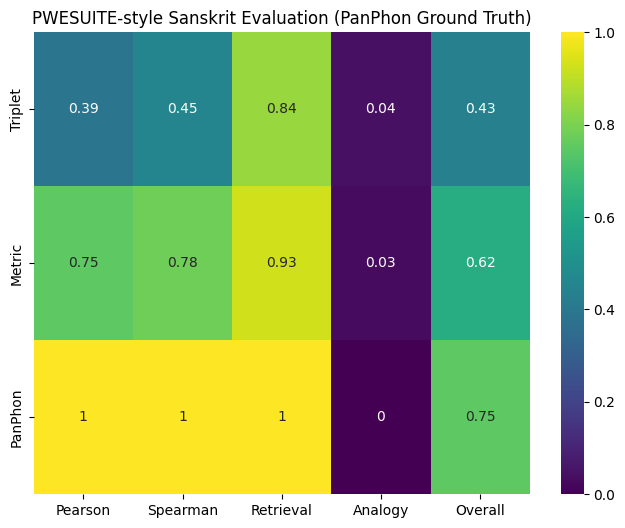

In [18]:
import pandas as pd

plt.figure(figsize=(8,6))
sns.heatmap(df_results, annot=True, cmap="viridis")
plt.title("PWESUITE-style Sanskrit Evaluation (PanPhon Ground Truth)")
plt.show()